# Ch03 TrendFollowing(A233740)

In [185]:
import numpy as np 
import pandas as pd 
import pyfolio as pf

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime
from adv_finance import bars, labeling, utils

from matplotlib.patches import Rectangle
import matplotlib.dates as mdates


In [186]:
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [187]:
%load_ext autoreload 
%autoreload 2


plt.style.use('seaborn-talk')
plt.style.use('bmh')
pd.set_option('display.max_rows', 100)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fit a Primary Model: Trend Following

In [188]:
# TRADE_A233740 = pd.read_parquet('/nfs/data/interim_2018/TRADE_A233740.parq')

In [189]:
TRADE_A233740_DRB = pd.read_parquet('/nfs/data/interim_2018/TRADE_A233740_DRB.parq')
df = TRADE_A233740_DRB[['open', 'high', 'low', 'close', 'vol']].drop_duplicates()
df = df.loc[~df.index.duplicated(keep='first')]
data = df

In [190]:
# compute moving average 
fast_window = 3
slow_window = 7

data['fast_mavg'] = data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
data['slow_mavg'] = data['close'].rolling(window=slow_window, min_periods=fast_window, center=False).mean()
data.head()

,open,high,low,close,vol,fast_mavg,slow_mavg
timestamp,,,,,,,
2018-01-02 09:04:56.303,19800,19800,19800,19800,111,NaN,NaN
2018-01-02 09:20:01.166,19800,19800,19800,19800,2001,NaN,NaN
2018-01-02 10:00:03.348,19800,19980,19800,19980,213856,19860.000000,19860.0
2018-01-02 10:01:30.166,19980,20080,19980,20080,200322,19953.333333,19915.0
2018-01-02 10:02:09.479,20080,20165,20075,20165,154758,20075.000000,19965.0


In [191]:
# Compute sides 
data['side'] = np.nan 

long_signals = data['fast_mavg'] >= data['slow_mavg']
short_signals = data['fast_mavg'] < data['slow_mavg']
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove look ahead bias by lagging the signal 
# data['side'] = data['side'].shift(1)


In [192]:
raw_data = data.copy()
data.dropna(axis=0, how='any', inplace=True)

## FIlter Events: CUSUM Filter

In [193]:
daily_vol = utils.get_daily_vol(data[['close']])
threshold = daily_vol['close'].mean() * 0.5


In [194]:
%%time
t_events = labeling.cusum_filter(data[['close']], threshold)
v_barriers = labeling.add_vertical_barrier(t_events=t_events, close=data[['close']], num_days=1)

CPU times: user 23.5 s, sys: 0 ns, total: 23.5 s
Wall time: 23.5 s


## Side Decision by Cusum Filter & Triple Barrier

In [239]:
%%time
pt_sl = [1,1]
min_ret = 0.01 
t_side_events = labeling.get_events(close=df['close'],
                                            t_events=t_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol['close'],
                                            min_ret=min_ret,
                                            num_threads=8,
                                            vertical_barrier_times=v_barriers,
                                            side_prediction=None)

side_labels = labeling.get_bins(t_side_events, df[['close']])

/nfs/code/adv_finance/adv_finance/labeling/labeling.py:111: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-05-27 09:46:59.380941 100.0%apply_pt_sl_on_t1 done after 0.05 minutes. Remaining 0.0 minutes.


CPU times: user 213 ms, sys: 56.7 ms, total: 270 ms
Wall time: 3.06 s


In [241]:
%%time
pt_sl = [1, 2]
min_ret = 0.01
t_barrier_events = labeling.get_events(close=df['close'],
                                            t_events=t_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol['close'],
                                            min_ret=min_ret,
                                            num_threads=8,
                                            vertical_barrier_times=v_barriers,
                                       side_prediction=side_labels['bin'])
#                                             side_prediction=data['side'])


/nfs/code/adv_finance/adv_finance/labeling/labeling.py:111: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
/nfs/code/adv_finance/adv_finance/labeling/labeling.py:123: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  side_ = side_prediction.loc[target.index]
2019-05-27 09:47:30.492342 100.0%apply_pt_sl_on_t1 done after 0.05 minutes. Remaining 0.0 minutes.


CPU times: user 120 ms, sys: 61.1 ms, total: 181 ms
Wall time: 2.98 s


In [243]:
labels = labeling.get_bins(t_barrier_events, df[['close']])


labels.side.value_counts()

-1.0    1133
 1.0    1030
 0.0     599
Name: side, dtype: int64

## Results of Primary Model: 

In [244]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print('Confusion Matrix')
print(confusion_matrix(actual, pred))

print('')
print('Accuracy')
print(accuracy_score(actual, pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       599
           1       0.78      1.00      0.88      2163

   micro avg       0.78      0.78      0.78      2762
   macro avg       0.39      0.50      0.44      2762
weighted avg       0.61      0.78      0.69      2762

Confusion Matrix
[[   0  599]
 [   0 2163]]

Accuracy
0.7831281679942071


/opt/conda/envs/python372/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Fit a Meta Model 

In [245]:
%%time
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()


# Serial Correlation (Takes about 4 minutes)
window_autocorr = 15
raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

CPU times: user 1min 36s, sys: 11.5 ms, total: 1min 36s
Wall time: 1min 36s


In [246]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [200]:
# Remove look ahead bias
# raw_data = raw_data.shift(1)

### Now get the data at the specified events

In [247]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

### Balance classes

In [248]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-02':'2018-11-01']
y_training_validation = y['2018-01-02':'2018-11-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.20, shuffle=False)

In [249]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

1    1394
0     445
Name: bin, dtype: int64

In [250]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    445
0    445
Name: bin, dtype: int64

In [251]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

## Fit a model

In [252]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [253]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.54268506 0.5872125  0.58855554 0.58894806 0.59127189 0.60078503
 0.60698198 0.55313634 0.60378744 0.60542945 0.60468581 0.6022123
 0.60930563 0.61583265 0.51966708 0.60535118 0.60772291 0.62187288
 0.6266299  0.62895663 0.63287728 0.55759891 0.59872511 0.62333612
 0.62003944 0.62202779 0.62811429 0.63634405 0.58195975 0.61568641
 0.63497715 0.63639611 0.64526069 0.65589906 0.65953809]
512 7 42


In [254]:
# Refit a new model with best params, so we can see feature importance
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Training Metrics

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       445
           1       0.94      0.95      0.95       445

   micro avg       0.94      0.94      0.94       890
   macro avg       0.95      0.94      0.94       890
weighted avg       0.95      0.94      0.94       890

Confusion Matrix
[[417  28]
 [ 21 424]]

Accuracy
0.9449438202247191


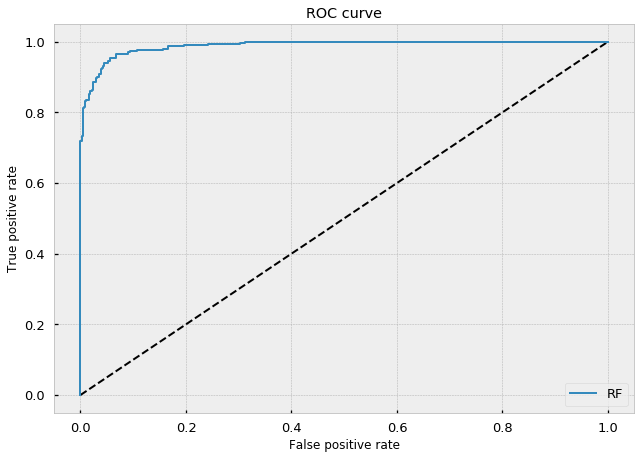

In [255]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Validation Metrics

              precision    recall  f1-score   support

           0       0.11      0.62      0.19        42
           1       0.93      0.50      0.65       418

   micro avg       0.51      0.51      0.51       460
   macro avg       0.52      0.56      0.42       460
weighted avg       0.85      0.51      0.61       460

Confusion Matrix
[[ 26  16]
 [209 209]]

Accuracy
0.5108695652173914


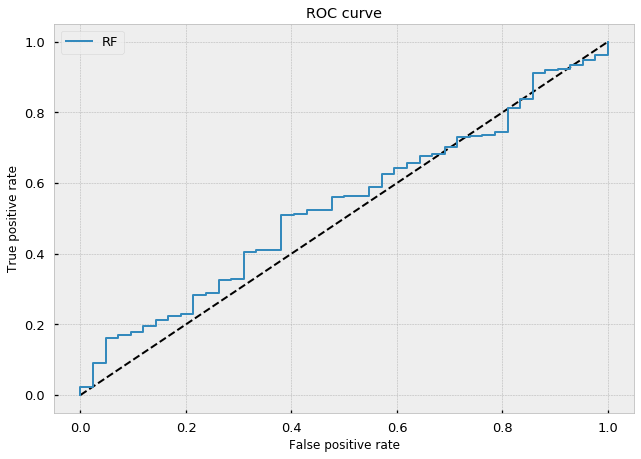

In [256]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [257]:
print(X_validate.index.min())
print(X_validate.index.max())

2018-10-04 11:00:49.360000
2018-11-01 10:02:32.063000


In [258]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc(X_validate.index.min())
end = primary_forecast.index.get_loc(X_validate.index.max()) + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.91      1.00      0.95       418

   micro avg       0.91      0.91      0.91       460
   macro avg       0.45      0.50      0.48       460
weighted avg       0.83      0.91      0.87       460

Confusion Matrix
[[  0  42]
 [  0 418]]

Accuracy
0.908695652173913


/opt/conda/envs/python372/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


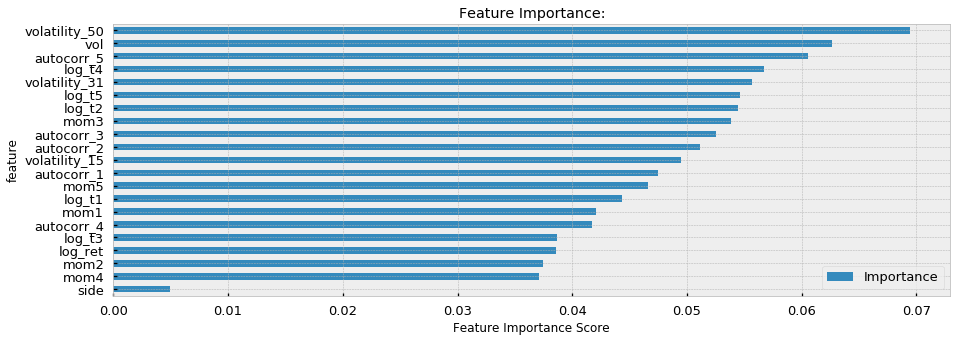

In [259]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

# Performance Tear Sheets(In-sample)

### Without Meta Labeling

In [260]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [261]:
valid_dates = X_validate.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

In [262]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [263]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

pf.show_perf_stats(primary_model_rets)

/opt/conda/envs/python372/lib/python3.7/site-packages/empyrical/stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Start date,2018-10-05
End date,2018-11-01
Total months,0
,Backtest
Annual return,2.1648400391158529e+49%
Cumulative returns,571089.0%
Annual volatility,1096.1%
Sharpe ratio,14.76
Calmar ratio,NaN
Stability,0.91
Max drawdown,0.0%


### With Meta Labeling 

In [264]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [265]:
# Save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

/opt/conda/envs/python372/lib/python3.7/site-packages/empyrical/stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Start date,2018-10-05
End date,2018-11-01
Total months,0
,Backtest
Annual return,2.6511918266958297e+25%
Cumulative returns,7127.8%
Annual volatility,386.4%
Sharpe ratio,16.84
Calmar ratio,NaN
Stability,0.90
Max drawdown,0.0%


# Perform out-of-sample test 

## Meta Model Metrics

In [266]:
# Extarct data for out-of-sample (OOS)
X_oos = X['2018-11-02':]
y_oos = y['2018-11-02':]

              precision    recall  f1-score   support

           0       0.24      0.62      0.35       112
           1       0.76      0.39      0.52       351

   micro avg       0.44      0.44      0.44       463
   macro avg       0.50      0.50      0.43       463
weighted avg       0.64      0.44      0.48       463

Confusion Matrix
[[ 69  43]
 [214 137]]

Accuracy
0.4449244060475162


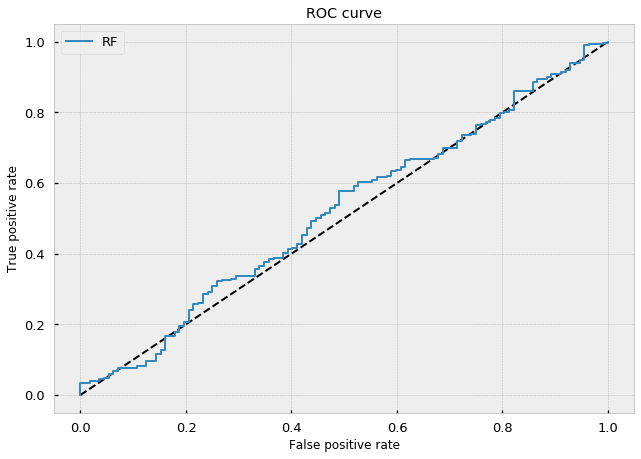

In [267]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [268]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2018-01-02':]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       599
           1       0.78      1.00      0.88      2163

   micro avg       0.78      0.78      0.78      2762
   macro avg       0.39      0.50      0.44      2762
weighted avg       0.61      0.78      0.69      2762

Confusion Matrix
[[   0  599]
 [   0 2163]]

Accuracy
0.7831281679942071


/opt/conda/envs/python372/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Primary Model(Test Data)

In [269]:
test_dates = X_oos.index

# Downsample to daily
prim_rets_test = labels.loc[test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=daily_rets_prim, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(daily_rets_prim)

/opt/conda/envs/python372/lib/python3.7/site-packages/empyrical/stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Start date,2018-11-05
End date,2018-12-28
Total months,1
,Backtest
Annual return,1.0829620346925808e+22%
Cumulative returns,151290.1%
Annual volatility,272.5%
Sharpe ratio,19.58
Calmar ratio,NaN
Stability,0.97
Max drawdown,0.0%


## Meta Model(Test Data)

/opt/conda/envs/python372/lib/python3.7/site-packages/empyrical/stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/opt/conda/envs/python372/lib/python3.7/site-packages/empyrical/stats.py:1511: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2018-11-05
End date,2018-12-28
Total months,1
,Backtest
Annual return,7171364684.5%
Cumulative returns,1665.7%
Annual volatility,132.7%
Sharpe ratio,14.68
Calmar ratio,NaN
Stability,0.95
Max drawdown,0.0%


/opt/conda/envs/python372/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2018-11-05,2018-11-05,2018-11-05,1
1,0.00,2018-11-05,2018-11-05,2018-11-05,1
2,0.00,2018-11-05,2018-11-05,2018-11-05,1
3,0.00,2018-11-05,2018-11-05,2018-11-05,1
4,0.00,2018-11-05,2018-11-05,2018-11-05,1


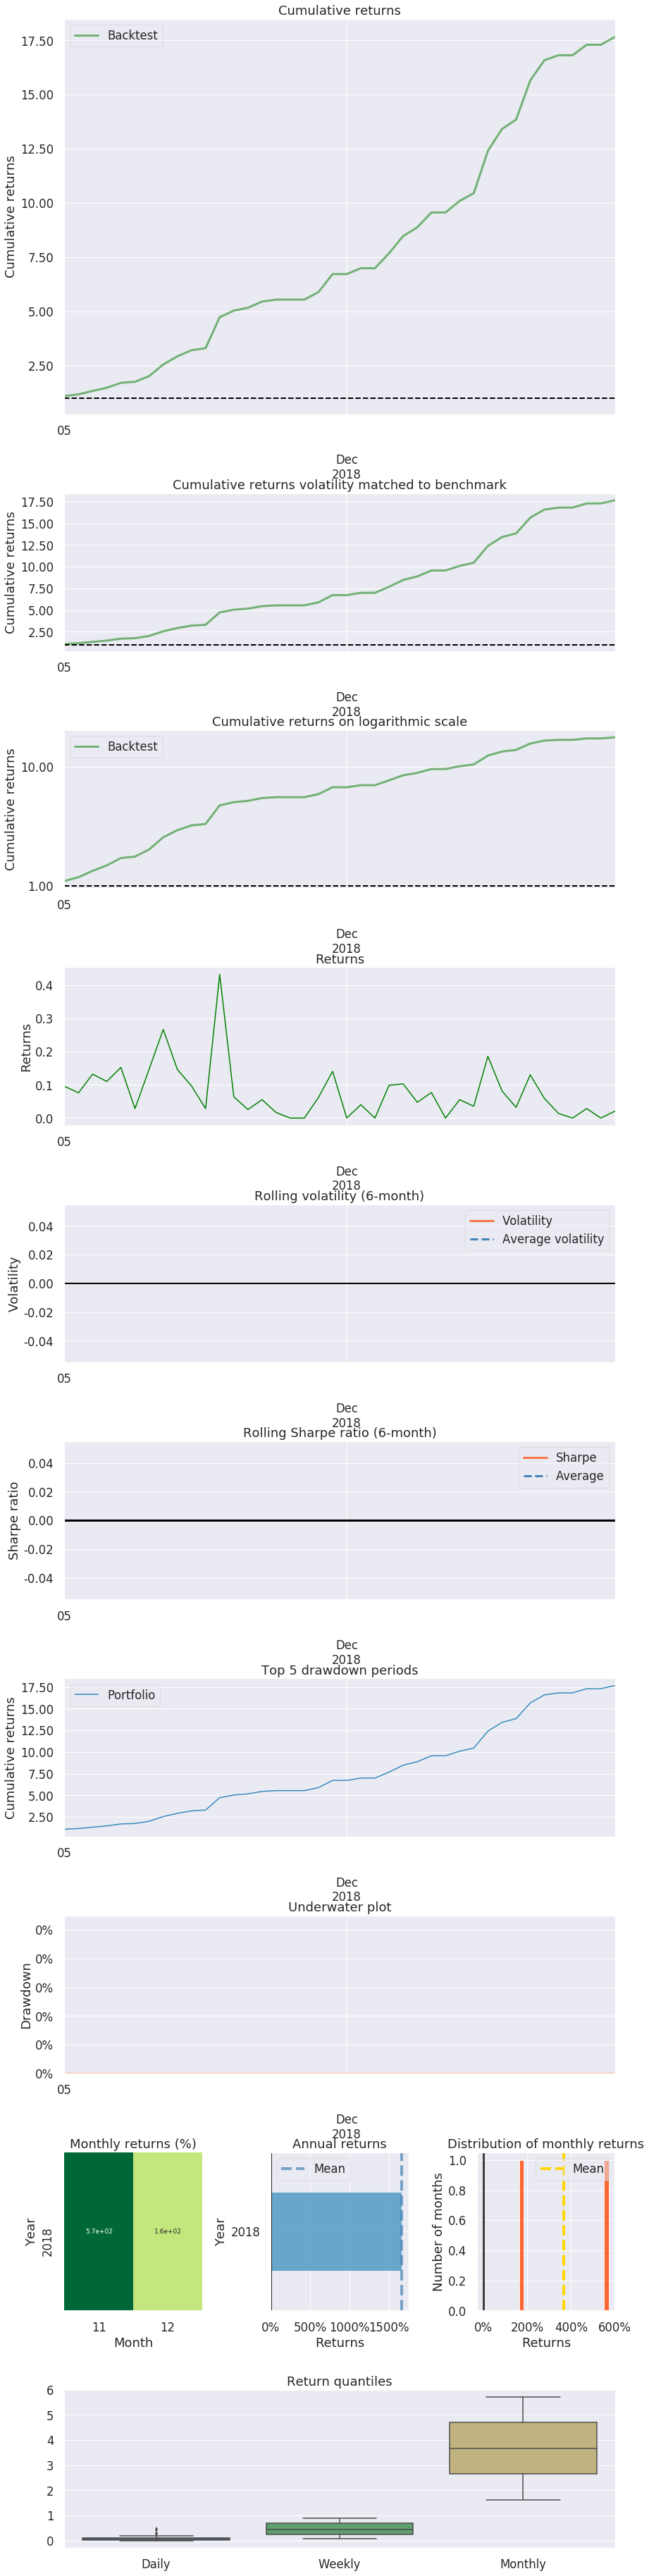

In [270]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)